# Mission pilot: GTR EDA

In this pilot, we are developing indicators to evaluate the impact of innovation missions.

We are doing this with Gateway to Research and Horizon 2020 data, and with two two missions in mind. They are:

* Use of AI to diagnose, prevent and treat chronic diseases
* Improve quality of life for an aging population

We want to write a pipeline that more or less automatically takes keywords related to missions, queries the data and generates indicators and visualisations.

The two datasets we are working with have similar structures (*projects linked to organisations and outcomes*) so it would be nice to write a pipeline that allows us to move between sources seamlessly.

The output will be a methodology and preliminary findings for a EURITO working paper. Emerging findings will also be relevant for the project mapping innovation in Scotland.

## Tasks

1. Load and explore GtR data
  * Link between projects and outcomes
  * Coverage of outcomes
  
2. Process GtR data
  * Classify projects into disciplines
  * Label projects with TRLs (this will come from other team-members)

3. Create mission fields
  * Generate mission-related keywords
  * Query the data

4. Generate indicators
  * Level of activity per mission
  * Evolution of activity per mission (absolute and normalised)
  * Network structure of mission
    * Interdisciplinary activity and its evolution
    * Communities involved
    * % of relevant fields involved in mission (eg how much of total AI activity is about chronic diseases; how much of aging is about quality of life and well-being)?
  * Technological maturity of fields
    * Explore distribution of outcomes by mission area
    * Generate lists of DOIs (papers) for cross-ref analysis
    
5. Report
   









### 0. Preamble

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Functions

def missing_count(df,ax):
    '''
    Creates a barchart with share of missing values by variable in the data
    
    '''
    
    df.apply(lambda x: pd.isnull(x),axis=1).mean().sort_values(ascending=False).plot.bar(ax=ax,color='blue')
    
def get_year(date):
    '''
    Extracts years from GTR data. These are strings so we just get the first number
    '''
    
    if pd.isnull(date)==False:
        y = date.split('-')[0]
        return(int(y))
    
    else:
        return(np.nan)



### 1. Load GtR data

We will load the data in a different Notebook (we need a special environment to use the data getters)

In [3]:
my_tables = ['_projects','_organisations','_products','_intellectualproperties','_publications',
             'technicalproducts',
             '_spinouts','_link_table']

In [4]:
all_tables = os.listdir('../data/external/gtr/2019-01-24/')

In [5]:
all_tables = os.listdir('../data/external/gtr/2019-01-24/')

#A dict where every item is a df with the key = table name. We do a bit of string manipulation to remove dates etc.
my_data = {file.split('_')[-1][:-4]:pd.read_csv('../data/external/gtr/2019-01-24/'+file).iloc[:,1:] for file in all_tables if any(x in file for x in my_tables)}


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
my_data.keys()

dict_keys(['table', 'organisations', 'locations', 'intellectualproperties', 'products', 'publications', 'softwareandtechnicalproducts', 'spinouts', 'projects'])

In [7]:
#Load the linking file here because we will use it throughout
link = my_data['table']

link.head()

,id,project_id,rel,table_name
0,00000C13-59F1-419B-9204-77DAFFD2BC35,D80FFDA0-64E3-4DB9-AE0D-2ECEBBDF2081,PUBLICATION,gtr_outcomes_publications
1,00000D8A-3BFA-4D6C-BB58-8721DA8D36E1,F229B185-CBF1-40D3-94B5-D47996220858,PUBLICATION,gtr_outcomes_publications
2,00002A95-E2E9-4DBA-8963-5F06E950793D,0364672B-D798-44FA-BA07-0AF4653D32FE,FUND,gtr_funds
3,00002C86-98D2-4681-992A-E6F180D197C0,5237EE5C-D46C-43E1-92AA-C0C73F5B291B,PI_PER,gtr_persons
4,00002C86-98D2-4681-992A-E6F180D197C0,92491E00-537A-4072-8877-A9D155E7FA73,SUPER_PER,gtr_persons


### Projects

In [8]:
projects = my_data['projects']

projects.head()

,id,end,title,status,grantCategory,leadFunder,abstractText,start,created,leadOrganisationDepartment,potentialImpact,techAbstractText
0,00006CB7-61E0-4946-B7DB-DAE09ED63DE4,NaN,Construction Site Monitoring,Closed,Vouchers,Innovate UK,We take aerial photos of construction sites us...,NaN,2018-11-08 11:38:37,NaN,NaN,NaN
1,0003C360-5DB8-4930-8266-6218C633A504,NaN,The 'Authoritarian Turn' in Environmental Gove...,Active,Studentship,ESRC,This research will investigate the possibility...,NaN,2018-11-08 11:38:37,Architecture Planning and Landscape,NaN,NaN
2,000423DA-5A37-4E62-A698-703985CD4E6E,NaN,Proton-driven plasma wakefield acceleration---...,Closed,Research Grant,STFC,"Over the last fifty years, accelerators of eve...",NaN,2018-11-08 11:38:37,Physics and Astronomy,This project is naturally a multi-disciplinary...,NaN
3,000424B1-378E-4AB6-BAEC-CD8607AE08A9,NaN,Mechanisms mediating axon outgrowth in the Dro...,Closed,Research Grant,BBSRC,We are dependent on our nervous system functio...,NaN,2018-11-08 11:38:37,Developmental Neurobiology,The research in this proposal will have a numb...,The formation of the nervous system requires t...
4,0004C698-0B51-4665-8593-1082BBF58C06,NaN,"Ultrahigh resolution NMR: citius, altius, fortius",Active,Research Grant,EPSRC,Understanding the structures and behaviour of ...,NaN,2018-11-08 11:38:37,Chemistry,Who will benefit from this research?\n\nNMR is...,NaN


Some rapid observations:

* what does start mean?
* What does created mean?
* abstractText seems to be the main textual description

Text(0.5,1,'Missing values in Project GTR data')

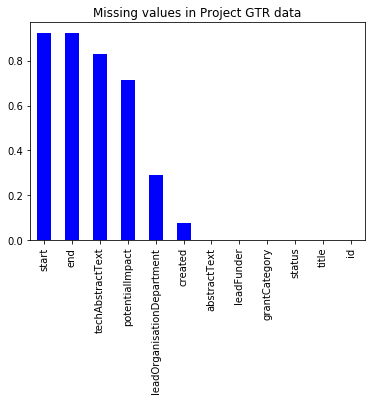

In [9]:
fig,ax = plt.subplots()

missing_count(projects,ax)

ax.set_title('Missing values in Project GTR data')

In [10]:
projects['year_created'] = projects['created'].apply(lambda x: get_year(x))

projects['year_created'].value_counts()

2018.0    81136
2019.0     2048
Name: year_created, dtype: int64

Created is a data collection variable

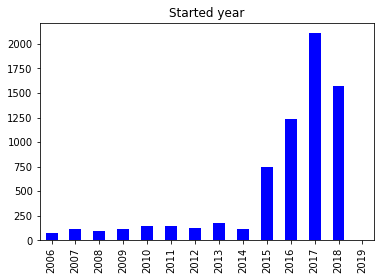

In [11]:
projects['year_started'] = projects['start'].apply(lambda x: get_year(x))

projects['year_started'].value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='Started year')

Not sure about what `year_stared` means but it doesn't cover many records

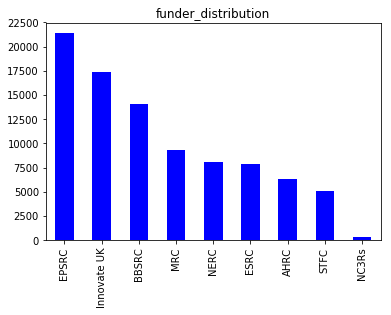

In [12]:
projects['leadFunder'].value_counts().plot.bar(color='blue',title='funder_distribution')

EPSRC and Innovate UK are the most active organisations in the data

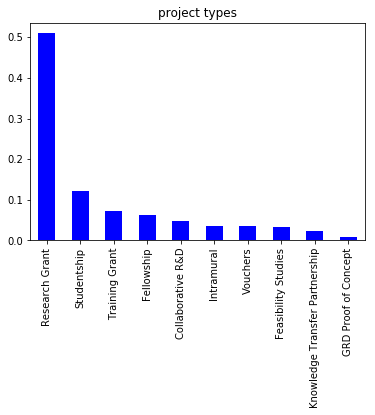

In [13]:
projects['grantCategory'].value_counts(normalize=True)[:10].plot.bar(color='blue',title='project types')

Research grants are the main category with almost half of the observations

##### Does the fund data contain the actual start and end date for the project?

In [14]:
fund = pd.read_csv('../data/external/gtr/2019-01-24/gtr_funds.csv').iloc[:,1:]

In [15]:
fund.head()

,id,end,start,category,amount,currencyCode
0,00002A95-E2E9-4DBA-8963-5F06E950793D,2015-01-31 00:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,5000,GBP
1,00003B8A-C3EB-4298-B7C2-971FC8AB05F0,2013-12-30 00:00:00,2012-03-31 01:00:00,INCOME_ACTUAL,363926,GBP
2,00005A36-BBB5-45B3-BF64-8AE86FF230E4,2022-03-31 01:00:00,2018-10-01 01:00:00,INCOME_ACTUAL,0,GBP
3,00006E7F-2E72-4CE6-81D4-2B603E5E4526,2018-09-30 01:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,379758,GBP
4,00009856-0B8F-406E-ABC6-F56064AE88E4,2020-11-30 00:00:00,2018-08-01 01:00:00,INCOME_ACTUAL,110498,GBP


In [16]:
fund.shape

(173734, 6)

One fund per project. Bodes well

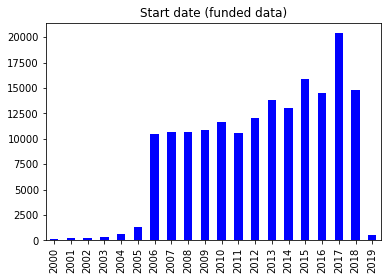

In [17]:
fund['year'] = fund['start'].apply(lambda x: get_year(x))

fund['year'].value_counts().loc[np.arange(2000,2020)].plot.bar(color='blue',title='Start date (funded data)')

The dataset begins in 2016. What is the bump in 2017?

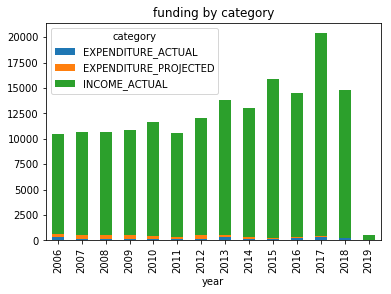

In [18]:
pd.crosstab(fund['category'],fund['year'])[np.arange(2006,2020)].T.plot.bar(stacked=True,title='funding by category')

Most of the funding levels in the data reflect income

#### Merge funding with projects to get dates and funding by project

`projects_f = projects merged w/ funding`

In [19]:
#Merge everything. It works

projects_f = pd.merge(
    pd.merge(fund,link,left_on='id',right_on='id'),
    projects,
    left_on='project_id',right_on='id')

In [20]:
projects_f.head()

,id_x,end_x,start_x,category,amount,currencyCode,year,project_id,rel,table_name,...,grantCategory,leadFunder,abstractText,start_y,created,leadOrganisationDepartment,potentialImpact,techAbstractText,year_created,year_started
0,00002A95-E2E9-4DBA-8963-5F06E950793D,2015-01-31 00:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,5000,GBP,2014,0364672B-D798-44FA-BA07-0AF4653D32FE,FUND,gtr_funds,...,Vouchers,Innovate UK,Billcompare UK is a consumer orientated websit...,NaN,2018-11-08 11:38:37,NaN,NaN,NaN,2018.0,NaN
1,0856EB64-6390-4A6F-BDE3-D399A42C3E55,2015-01-31 00:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,5000,GBP,2014,0364672B-D798-44FA-BA07-0AF4653D32FE,FUND,gtr_funds,...,Vouchers,Innovate UK,Billcompare UK is a consumer orientated websit...,NaN,2018-11-08 11:38:37,NaN,NaN,NaN,2018.0,NaN
2,00003B8A-C3EB-4298-B7C2-971FC8AB05F0,2013-12-30 00:00:00,2012-03-31 01:00:00,INCOME_ACTUAL,363926,GBP,2012,52405730-6906-4BDD-B9FC-FEB8E6C97E84,FUND,gtr_funds,...,Research Grant,BBSRC,People in the UK are getting fatter and this h...,NaN,2018-11-08 11:38:37,MRC Human Nutrition Research,Understanding the roles of the PPARs in regula...,PPAR-delta is a receptor that is highly expres...,2018.0,NaN
3,9B0B99D8-E22E-4B93-8BEC-ECB6625E8AEE,2013-12-30 00:00:00,2012-03-31 01:00:00,INCOME_ACTUAL,363926,GBP,2012,52405730-6906-4BDD-B9FC-FEB8E6C97E84,FUND,gtr_funds,...,Research Grant,BBSRC,People in the UK are getting fatter and this h...,NaN,2018-11-08 11:38:37,MRC Human Nutrition Research,Understanding the roles of the PPARs in regula...,PPAR-delta is a receptor that is highly expres...,2018.0,NaN
4,00005A36-BBB5-45B3-BF64-8AE86FF230E4,2022-03-31 01:00:00,2018-10-01 01:00:00,INCOME_ACTUAL,0,GBP,2018,CBA76D0D-2D95-4028-B8DE-65041D8D1F85,FUND,gtr_funds,...,Studentship,EPSRC,The reactor pressure vessel (RPV) is a safety ...,2018-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,2018.0


Lots of guff there. I should tidy it up later

#### Let's also check the Topics: does this refer to project keywords?

In [21]:
topics = pd.read_csv('../data/external/gtr/2019-01-24/gtr_topic.csv').iloc[:,1:]

topics.head()

,id,text,topic_type
0,006DC612-6329-4D37-A540-5FB2CA634720,5.5 Radiotherapy,researchActivity
1,008D950C-182A-427B-A7CB-4FD430D040B5,Physical Organic Chemistry,researchTopic
2,00C03EE8-351D-40B5-A0D4-06C45592BFF6,Nuclear structure,researchTopic
3,00E432A0-CF0E-42D0-BAF1-6872995B42EF,Part. Phys/Astron. Instrument.,researchTopic
4,01AC56BC-45B4-434D-B015-7C879327F09F,Parallel Computing,researchTopic


In [22]:
topics['topic_type'].value_counts()

researchTopic       594
researchSubject      82
researchActivity     49
healthCategory       22
rcukProgramme         2
Name: topic_type, dtype: int64

Yes. What are their keys in the linked_table?

In [23]:
link['table_name'].value_counts()

gtr_outcomes_publications                    1392608
gtr_outcomes_disseminations                   454795
gtr_organisations                             228991
gtr_persons                                   192754
gtr_outcomes_collaborations                   188683
gtr_funds                                     173699
gtr_outcomes_furtherfundings                  126405
gtr_topic                                      61632
gtr_outcomes_keyfindings                       54390
gtr_outcomes_policyinfluences                  44544
gtr_outcomes_impactsummaries                   37560
gtr_outcomes_researchmaterials                 30774
gtr_projects                                   21331
gtr_outcomes_researchdatabaseandmodels         20151
gtr_outcomes_artisticandcreativeproducts       13713
gtr_outcomes_softwareandtechnicalproducts      12227
gtr_outcomes_intellectualproperties             7749
gtr_outcomes_products                           4095
gtr_outcomes_spinouts                         

We can loop over the projects and allocate them topics

Create a research activity lookup and a research topic lookup.

In [24]:
res_activity_lookup,res_topic_lookup = [{this_id:text for this_id,text in zip(topics.loc[topics['topic_type']==topic_type,'id'],
                                                                             topics.loc[topics['topic_type']==topic_type,'text'])} for
                                        topic_type in ['researchActivity','researchTopic']]
                                                                              

In [25]:
list(res_activity_lookup.values())[:10]

['5.5  Radiotherapy',
 '6.4  Surgery',
 '5.8  Complementary',
 'HRCS Research Uncodeable',
 '6.2  Cellular and gene therapies',
 '1.4  Methodologies and measurements',
 '3.2  Interventions to alter physical and biological environmental risks',
 '1.5  Resources and infrastructure (underpinning)',
 '2.1  Biological and endogenous factors',
 '6.9  Resources and infrastructure (evaluation of treatments)']

`researchActivity` is a medical set of subjects

In [26]:
list(res_topic_lookup.values())[:10]

['Physical Organic Chemistry',
 'Nuclear structure',
 'Part. Phys/Astron. Instrument.',
 'Parallel Computing',
 'Plant developmental biology',
 'Chemical Biology',
 'Continuum Mechanics',
 'Time-Based Media HTP',
 'Biophysics',
 'Central Laser Facility']

`researchTopics` is generic

### Organisations


In [27]:
orgs = my_data['organisations']

orgs.head()

,id,name,addresses,projectCost,grantOffer
0,0003EB78-07B9-400E-AE39-2AD612C28612,Wentworth Laboratories Ltd,{'address': {'id': '18A52282-3BCD-483D-A32F-F3...,NaN,NaN
1,0005728F-26ED-465D-8DCE-C49F181EDB2E,Duchy Parade Films,{'address': {'id': '1788E06A-79D8-492F-9988-62...,NaN,NaN
2,0005AEA8-B99E-4063-973E-FF16602F9CCF,"German Mouse Clinic, Helmholtz Zentrum Münster",NaN,NaN,NaN
3,000775C1-64AC-4140-A8EC-9C4B337DB8EE,Dynamic Boosting Systems Limited,{'address': {'id': 'E143A689-8121-40FB-968D-46...,319806.0,143913.0
4,0007ED76-4B09-4B09-A39F-D4B75BD36486,Hildersham Village History Recorders,NaN,NaN,NaN


In [28]:
orgs.shape

(39349, 5)

This will be interesting to look at collaboration networks between organisations.

Note that this is likely to over-estimate collaboration given that departments (which might be disconnected) will be subsumed under organisations. Maybe we could use the persons data to unpick that?

### Outputs

Brief exploration of the data and standardisation with a single schema (for merging with projects)

#### Products

In [29]:
products = my_data['products']

In [30]:
products.head()

,id,title,description,type,stage,status,yearDevelopmentCompleted,impact,supportingUrl
0,0001B33F-9572-4464-BF3B-9AC695F57C9D,Nat-His-MTM,Prospective longitudinal study of the natural ...,Management of Diseases and Conditions,Initial development,Under active development/distribution,2013.0,None as yet.,NaN
1,0003293D-247D-4BF1-9674-402A70504D64,Normothermic machine liver perfusion of discar...,Deaths from liver disease have soared by 40 pe...,Therapeutic Intervention - Medical Devices,Early clinical assessment,Under active development/distribution,2016.0,First human liver transplantation using a marg...,NaN
2,002C330E-54B9-48F7-B97E-82D25A7C4E8A,Public health intervention design,The public health intervention under developme...,Health and Social Care Services,Refinement. Non-clinical,Under active development/distribution,2017.0,It is under refinement stage. It is not yet im...,NaN
3,0037AC05-B957-498A-96B6-2B2F732A2FDD,Insertion-and-deletion-derived tumour-specific...,"Regarding the CPI predictive test technology, ...",Diagnostic Tool - Non-Imaging,Initial development,Under active development/distribution,2018.0,Despite the recent clinical success of immunot...,NaN
4,0047A6B5-2377-47A1-8D63-360B5400E5B9,Novel compounds with antibacterial activity,Dr. Andrews team has synthesised several novel...,Therapeutic Intervention - Drug,Initial development,Under active development/distribution,2016.0,Dr Andrews work takes a novel approach by incr...,NaN


In [31]:
products.shape

(4095, 9)

They seem to be primarily medical products

In [32]:
products.stage.value_counts()

Initial development          1142
Early clinical assessment    1004
Late clinical evaluation      587
Refinement.  Non-clinical     488
Refinement.  Clinical         343
Small-scale adoption          239
Wide-scale adoption           149
Market authorisation           82
Name: stage, dtype: int64

In [33]:
products.type.value_counts()

Therapeutic Intervention - Drug                                      1160
Diagnostic Tool - Non-Imaging                                         617
Therapeutic Intervention - Medical Devices                            331
Diagnostic Tool - Imaging                                             255
Therapeutic Intervention - Cellular and gene therapies                197
Therapeutic Intervention - Vaccines                                   197
Support Tool - For Medical Intervention                               194
Preventative Intervention - Behavioural risk modification             191
Management of Diseases and Conditions                                 184
Support Tool - For Fundamental Research                               178
Therapeutic Intervention - Psychological/Behavioural                  175
Preventative Intervention - Nutrition and Chemoprevention              74
Therapeutic Intervention - Surgery                                     62
Health and Social Care Services       

Yes - this is clearly a medical database. We might use it for our two missions given their health focus

#### Intellectual Property

In [34]:
ip = my_data['intellectualproperties']

ip.head()

,id,title,description,protection,patentId,yearProtectionGranted,impact,licensed
0,00042331-9D9F-48B3-AF06-3546D8BAC01D,FBG strain sensor,Design of FBG-based sensor for monitoring corr...,Patent application published,GB2439993-2008-01-16,2008,This will make an impact in the construction i...,No
1,000670D2-9E0E-401F-96F8-594DF4599FD7,Analogs of alpha ceramide (IMM47) and uses the...,Analogs of alpha ceramide (IMM47) and uses the...,Patent granted,6836514.7,2007,"In this patent, which underpinned my subsequen...",Yes
2,001A3285-86DE-4DEE-8D6B-C1D92BE6CDFC,IDENTIFICATION AND DISPLAY OF PEPTIDE LIGANDS,An in vitro drug discovery platform analogous ...,Patent application published,WO 2015/011467,2015,z,No
3,001F8DBA-72DA-49F6-8588-628088BCCCB1,LIST BASED PREFETCH,Invention of a pattern-recording gather prefet...,Patent granted,US8255633,2012,Used in IBM's HPC products,Com
4,0024B4B4-BB74-4AC1-8D68-F2771E80383B,Terahertz radiation detector focal plane array...,A CMOS based focal plane for terahertz imaging...,Patent granted,US9513171,2016,Collaboration with industry on photonics techn...,Com


In [35]:
ip.shape

(7749, 8)

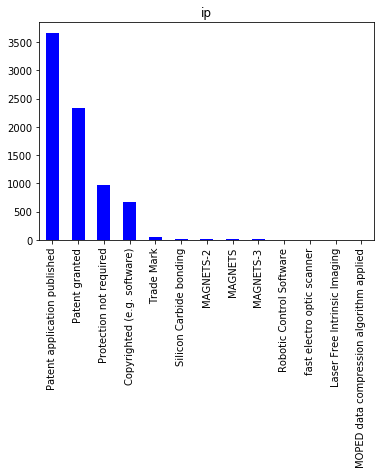

In [36]:
ip.protection.value_counts().plot.bar(color='blue',title='ip')

Around 3000 patents and a bunch of random labels. We can use it perhaps to look at field maturity

#### Technical products

In [37]:
technical = my_data['softwareandtechnicalproducts']

technical.head()

,id,title,description,type,impact,softwareOpenSourced,yearFirstProvided,supportingUrl
0,00043B35-DCD5-4C1C-B5FF-FD2B451AABF0,cath-cluster: A simple way to complete-linkage...,The software provides a fast implementation of...,Software,The software has increased visibility of our g...,True,2018.0,http://cath-tools.readthedocs.io/en/latest/too...
1,00050BA4-9FA9-405E-9210-6DB9C888DD4C,Submarine Canyons: guest post,website by Siddhi Joshi,Software,NaN,NaN,NaN,http://seabedhabitats.org/2013/06/24/submarine...
2,00079818-77E3-4CF2-AD5F-00283863AC3C,ICMplus,ICU monitoring software. Developed by Marek Cz...,Software,Take up internationally,NaN,NaN,NaN
3,0009EC96-A733-45BF-A5F2-369DFDD232FF,INRFlow - update needed,Interconnection network research flow-level ev...,Software,.,True,2016.0,NaN
4,0013CA23-C0A9-4537-80AE-641CEBD36AAC,AutoLens,AutoLens is a new piece of strong gravitationa...,Software,Expectations are that AutoLens or at least man...,NaN,2018.0,NaN


In [38]:
technical.shape

(12227, 8)

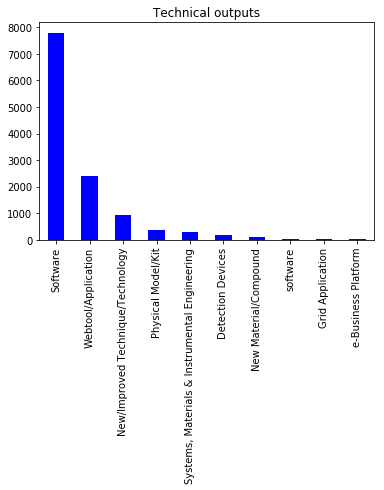

In [39]:
technical['type'].value_counts().plot.bar(color='blue',title='Technical outputs')

Perhaps we could create a 'practical output' dummy for the field...

Or query the application databases with project names once we have identified them?

In [40]:
np.sum(['github' in x for x in technical.supportingUrl if pd.isnull(x)==False])

1686

1686 projects in GitHUb

#### Spinouts

In [41]:
spinouts = my_data['spinouts']

spinouts.head()

,id,description,companyName,impact,website,yearEstablished
0,0052AC2C-FFC3-4E80-8D48-23D312BCCFB6,A special purpose vehicle set up to facilitate...,SPECIFIC Innovations Ltd,One technology licence has been granted to a c...,NaN,2014.0
1,00835229-1A18-4731-BA53-F13EFFF8C4C7,Scientific text mining,Scidiver,None so far.,NaN,2011.0
2,00911DF1-AF41-42EC-BB95-6FC28E86786C,Cognition Video is a platform for the automati...,Cognition Video Ltd.,Cognition Video won the Enterprise Software ca...,http://www.cognitionvideo.co.uk,2016.0
3,00958DA0-A15A-4DA0-B2EF-056E21C44BFE,To exploit the sensors and composites innovati...,Sensors and Composites Ltd,Incorporated in 2015.,NaN,2015.0
4,00CC435B-DCD1-407A-9BF5-3F82240703E3,The company specializes in the area of manufac...,VitriTech Ltd,Technology for laser gain manufacturing has be...,http://www.vitritech.co.uk/,2015.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


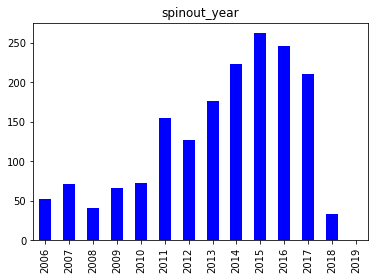

In [42]:
spinouts.yearEstablished.value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='spinout_year')

#### Publications

In [43]:
pubs = my_data['publications']

pubs.head()

,id,title,type,journalTitle,datePublished,publicationUrl,pubMedId,issn,volumeTitle,doi,issue,author,isbn,chapterTitle,pageReference
0,00000C13-59F1-419B-9204-77DAFFD2BC35,Characteristics of EGRET Blazars in the VLBA I...,Journal Article/Review,The Astrophysical Journal,2007-01-01,http://dx.doi.org/10.1086/523264,NaN,NaN,NaN,http://dx.doi.org/10.1086/523264,2,Taylor G,NaN,NaN,NaN
1,00000D8A-3BFA-4D6C-BB58-8721DA8D36E1,The cytotoxicity and cell labelling efficacy o...,Working Paper,NaN,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Samantha Parsons (Author),NaN,NaN,NaN
2,000030A0-2369-4D9A-8126-E68EE6FD653F,Altered receptor specificity and cell tropism ...,Journal Article/Review,Journal of virology,2010-01-01,http://europepmc.org/abstract/MED/20826688,20826688.0,0022-538X,84,http://dx.doi.org/10.1128/JVI.01639-10,22,Liu Y,NaN,NaN,NaN
3,0000428D-17F4-4E75-BD8A-8584675CAFAB,Nonlocal energy density functionals for pairin...,Journal Article/Review,Journal of Physics G: Nuclear and Particle Phy...,2017-01-01,http://dx.doi.org/10.1088/1361-6471/aa5fd7,NaN,NaN,NaN,http://dx.doi.org/10.1088/1361-6471/aa5fd7,4,Bennaceur K,NaN,NaN,NaN
4,00004300-5697-455F-A2A9-575AB7AA28E8,HCO (3)(-) secretion and CaCO3 precipitation p...,Journal Article/Review,"American journal of physiology. Regulatory, in...",2010-01-01,http://europepmc.org/abstract/MED/20130226,20130226.0,0363-6119,298,http://dx.doi.org/10.1152/ajpregu.00545.2009,4,Whittamore JM,NaN,NaN,NaN


In [44]:
np.random.randint(0,len(pubs),40000)

array([1188624,  192117, 1284055, ...,  508647,  384454,  306703])

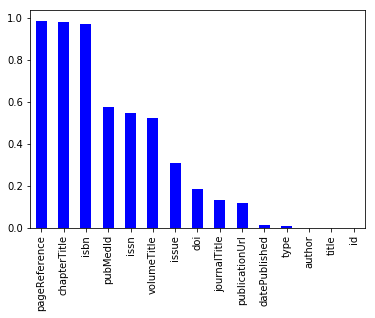

In [45]:
#Get missing values for a random sample (10%) of the publications

fig,ax = plt.subplots()

pub_sample = pubs.loc[list(np.random.randint(0,len(pubs),70000)),:]

missing_count(pub_sample,ax)


80% have DOI

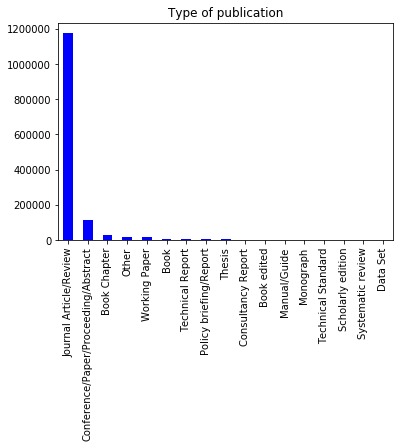

In [46]:
pubs.type.value_counts().plot.bar(color='blue',title='Type of publication')

In [47]:
pubs['year'] = pubs['datePublished'].apply(get_year)

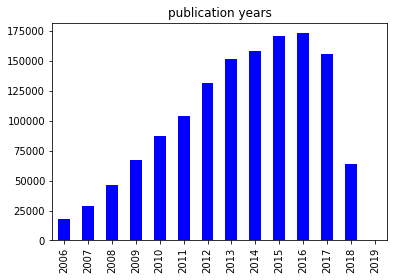

In [48]:
pubs['year'].value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='publication years')

In [49]:
pubs['journalTitle'].value_counts()[:10]

Monthly Notices of the Royal Astronomical Society         45340
Journal of High Energy Physics                            34476
Physical Review D                                         33471
Physical review letters                                   27722
Physics Letters B                                         24943
The Astrophysical Journal                                 20505
PloS one                                                  19100
The European physical journal. C, Particles and fields    12341
Astronomy & Astrophysics                                  11514
Scientific reports                                         8430
Name: journalTitle, dtype: int64

### Discipline coverage check

Here we run outputs vs projects to get who were the funders. We want to check how much cross-organisation coverage there is in the data

We also identify projects that appear in different 'impact' databases

In [50]:
#Containers for the data
impactful_projects= []

impact_funders = [projects['leadFunder'].value_counts()]

impact_names = ['prods','ip','tech','spin','pubs']

for name,data in zip(impact_names,[products,ip,technical,spinouts,pubs]):
    
    #Merges outputs and projects via the product file
    
    merged = pd.merge(
        pd.merge(data,link,left_on='id',right_on='id'),
        projects,left_on='project_id',right_on='id')
    
    #number of times that a project appears in an output df
    project_counts = merged['project_id'].value_counts()
    project_counts.name = name
    
    #Put it with the featured projects
    impactful_projects.append(project_counts)
    
    
    #Funder impact by project
    funder_freqs = merged['leadFunder'].value_counts()
    funder_freqs.name = name
    
    #Merges with the outpi
    impact_funders.append(funder_freqs)
    

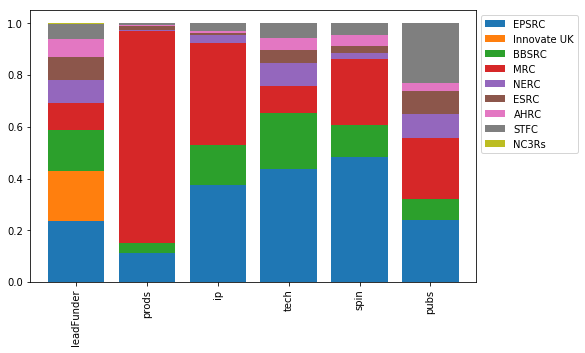

In [51]:
fig,ax = plt.subplots(figsize=(8,5))

pd.concat(impact_funders,axis=1,sort=False).apply(lambda x: x/x.sum(),axis=0).T.plot.bar(stacked=True,ax=ax,width=0.8)

ax.legend(bbox_to_anchor=(1,1))

Some observations:
* No output data for innovate UK
* MRC over-represented in all outputs (not bad for the mission pilots)
* STFC over-represented in publications(physics)

In [56]:
# And the impactful projects

#Concatenate the previous outputs
project_impacts = pd.concat(impactful_projects,axis=1,sort=True).fillna(0)

#Concatenate with the projects file
projects_imp = pd.concat([projects_f.set_index('project_id'),project_impacts],axis=1)

projects_imp.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


ValueError: Shape of passed values is (28, 173699), indices imply (28, 89843)

Fillnas with 0s. 
Should drop innovate from follow-on analyses here given that they don't seem to be tracking the impact of their projects in the same way as research councils.

In [ ]:
projects_imp[impact_names] = projects_imp[impact_names].fillna(0)

In [ ]:
import seaborn as sns

In [ ]:
#What is the correlation between different types of outputs...and level of funding?

projects_imp[impact_names+['amount']].corr()

Lots of potential confounders here - types of projects, disciplines...

#### Some observations for next steps

* Analysis focusing on 2006-2018
* We need to integrate the topic data (new link file)?
* Analyses of TRL/output by field will need to consider differences between disciplines in their outlets. To which extent are the disciplines in a mission field more or less productive than their constituent fields?
* ...



## 2. Process data

* Classify projects into disciplines.
  * I need the project topics for this labelling
* Any TRL tags would go in here

Add research activities and topics to the projects data

In [53]:
topic_lookup = link.loc[link['table_name']=='gtr_topic',:]

#We simply group by projects and run the names vs the research activity and topic lookup

#Group
res_topics_by_project = topic_lookup.groupby('project_id')

#Extract lookups
activity_project_lookup,topic_project_lookup = [res_topics_by_project['id'].apply(
    lambda x: [lookup[el] for el in [t for t in x] if el in lookup.keys()]).to_dict() for lookup in [res_activity_lookup,res_topic_lookup]]

In [55]:
#Add topics

projects_imp['research_topics'],projects_imp['research_activities']= [[
    lookup[x] if x in lookup.keys() else [] for x in projects_imp.index] for lookup in [
    topic_project_lookup,activity_project_lookup]]

NameError: name 'projects_imp' is not defined

In [54]:
projects_imp['has_topic'],projects_imp['has_activities'] = [[len(x)>0 for x in projects_imp[var]] for var in 
                                                            ['research_topics','research_activities']]
                                                            

NameError: name 'projects_imp' is not defined

In [ ]:
pd.crosstab(projects_imp.loc[projects_imp.grantCategory=='Research Grant','year'],
            projects_imp.loc[projects_imp.grantCategory=='Research Grant','has_topic'],normalize=0).plot.bar(
    stacked=True,title='Share of Research Grants with subject data')


Only around 80% of the projects have topics. This is quite different from previous versions of the data which had many more topics.

One to check with Joel

In [ ]:
fig,ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)

pd.crosstab(projects_imp['leadFunder'],projects_imp['has_topics'],normalize=0).plot.barh(stacked=True,ax=ax[0],legend=False)
pd.crosstab(projects_imp['leadFunder'],projects_imp['has_activities'],normalize=0).plot.barh(stacked=True,ax=ax[1])

Almost no topics in MRC - because they label their projects with activities.

For now we will use an older dataset with better topic coverage for labelling (see notebook `02_jmg_discipline_modelling`)

### Discipline classifier

Save data to train the model in the `02_jmg`... notebook

In [ ]:
gtr_for_pred = projects_imp.dropna(axis=0,subset=['abstractText'])

gtr_for_pred.to_csv(f'../data/processed/{today_str}_gtr_for_prediction.csv',index_label=False)

Load data after training

In [ ]:
gtr_predicted = pd.read_csv('../data/processed/24_1_2019_gtr_w_predicted_labels.csv',index_col=None).iloc[:,1:].set_index('index')

### Create a clean dataset

In [ ]:
discs = ['biological_sciences', 'physics', 'engineering_technology',
       'medical_sciences', 'social_sciences', 'mathematics_computing',
       'environmental_sciences', 'arts_humanities']

In [ ]:
my_vars = ['title','year','abstractText','status','grantCategory','leadFunder','amount']
rename_vars = ['title','year','abstract','status','grant_category','funder','amount']

proj_labelled = pd.concat([projects_imp,gtr_predicted],axis=1,sort=False)[my_vars + discs + impact_names]


proj_labelled.rename(columns={x:y for x,y in zip(my_vars,rename_vars)},inplace=True)

In [ ]:
#We will focus on projects with abstracts
proj_abst = proj_labelled.loc[gtr_predicted.index,:]

proj_abst.to_csv(f'../data/processed/{today_str}_projects_clean.csv')

Notebook `003` continues with the analysis